In [1]:
import pandas as pd
import numpy as np

from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.preprocessing import OneHotEncoder
from pandas.plotting import scatter_matrix
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import cross_val_score
from scipy import stats
import seaborn as sns
import re

import tables as tb

import pickle
import requests
import geocoder
from bs4 import BeautifulSoup
from collections import*
import matplotlib
import matplotlib.pyplot as plt
from PythonSrc.hdf5_getters import *

import PythonSrc.hdf5_getters as GETTERS


import os
import sys
import time
import glob
import datetime
import sqlite3

import unidecode

%matplotlib inline

/Users/thibautchamard/anaconda/lib/python3.6/site-packages/numexpr/cpuinfo.py:76: UserWarning: [Errno 2] No such file or directory: 'sysctl'
  stacklevel=stacklevel + 1):


### Create a dictionary:
This dictionary should match the maximum of those list of terms to a genre:
- `subset_unique_terms.txt`
- `subset_unique_mbtags.txt`

In [2]:
genre_dict = dict()

**Build a dictionary of the subgenres** 

To create a dictionary that associate a subgenre to its genre we used the data from the website: https://www.quora.com/What-is-the-basic-difference-between-different-genres-of-music-jazz-rock-pop-blues-rap-and-so-on

In [3]:
url = "https://www.quora.com/What-is-the-basic-difference-between-different-genres-of-music-jazz-rock-pop-blues-rap-and-so-on"

In [4]:
r = requests.get( url )
page_body = r.text
soup = BeautifulSoup(page_body, 'html.parser')

# Find all genres
genres = soup.findAll("p", class_="qtext_para")

for genre in genres :
    if genre.find('i') :
        
        # Classify the genre as a subgenre of its own genre
        genre_name = genre.find('i').text
        genre_name =  genre_name.replace(":", "").lower()
        genre_dict[genre_name] = genre_name
        
        # Find the subgenres
        subgenres = genre.find_next_sibling('ul')
        if subgenres : 
            subgenres = subgenres.findAll('li')
            
            # Add the subgenres to the disctionary
            for subgenre in subgenres :
                subgenre_name = subgenre.find('i').text
                genre_dict[subgenre_name.lower()] = genre_name

print("Dictionary of " + str( len(genre_dict) ) + " subgenres : ")                
genre_dict

Dictionary of 130 subgenres : 


{'acid jazz': 'jazz',
 'adult contemporary': 'pop',
 'african': 'world',
 'alternative': 'rock',
 'alternative hip hop': 'r&b',
 'ambient': 'electronica',
 'american roots': 'folk',
 'americana': 'rock',
 'art rock': 'rock',
 'asian': 'world',
 'avant-garde metal': 'metal',
 'beat pop': 'pop',
 'bebop': 'jazz',
 'big band': 'jazz',
 'black metal; ': 'metal',
 'bluegrass': 'country',
 'blues': 'blues',
 'blues rock': 'blues',
 'broadway': 'orchestral',
 'chicago blues': 'blues',
 'classic metal': 'metal',
 'classic rock': 'rock',
 'classical': 'orchestral',
 'college rock': 'rock',
 'country': 'country',
 'country pop': 'country',
 'dance pop': 'pop',
 'dancehall': 'reggae',
 'dark wave': 'rock',
 'death metal': 'metal',
 'delta blues': 'blues',
 'disco': 'pop',
 'doo wop': 'pop',
 'doom metal': 'metal',
 'dub': 'reggae',
 'dubstep': 'electronica',
 'eastern european': 'world',
 'electric blues': 'blues',
 'electronica': 'electronica',
 'folk': 'folk',
 'folk pop': 'folk',
 'folk rock':

On the above dictionary, we notice that the following subgenres are grouped together under the same dictionary entry, separated by slashes ' / ' : 

In [5]:
multiple_subgenres = [key for key, value in genre_dict.items() if '/' in key.lower()]
multiple_subgenres

['irish/celtic/gaelic', 'latin/hispanic']

Let's split those under several dictionary entries to increase the likelihood of a match to the tags of the MilionSongsDataset.

In [6]:
for multiple_subgenre in multiple_subgenres : 
    subgenres = multiple_subgenre.split("/")
    for subgenre in subgenres :
        genre_dict[subgenre] = genre_dict[multiple_subgenre]
        
for subgenre in multiple_subgenres:
    del genre_dict[subgenre]
    
print("Dictionary of " + str( len(genre_dict) ) + " subgenres : ")                
genre_dict

Dictionary of 133 subgenres : 


{'acid jazz': 'jazz',
 'adult contemporary': 'pop',
 'african': 'world',
 'alternative': 'rock',
 'alternative hip hop': 'r&b',
 'ambient': 'electronica',
 'american roots': 'folk',
 'americana': 'rock',
 'art rock': 'rock',
 'asian': 'world',
 'avant-garde metal': 'metal',
 'beat pop': 'pop',
 'bebop': 'jazz',
 'big band': 'jazz',
 'black metal; ': 'metal',
 'bluegrass': 'country',
 'blues': 'blues',
 'blues rock': 'blues',
 'broadway': 'orchestral',
 'celtic': 'world',
 'chicago blues': 'blues',
 'classic metal': 'metal',
 'classic rock': 'rock',
 'classical': 'orchestral',
 'college rock': 'rock',
 'country': 'country',
 'country pop': 'country',
 'dance pop': 'pop',
 'dancehall': 'reggae',
 'dark wave': 'rock',
 'death metal': 'metal',
 'delta blues': 'blues',
 'disco': 'pop',
 'doo wop': 'pop',
 'doom metal': 'metal',
 'dub': 'reggae',
 'dubstep': 'electronica',
 'eastern european': 'world',
 'electric blues': 'blues',
 'electronica': 'electronica',
 'folk': 'folk',
 'folk pop': '

Finally, we notice that some basics music genre are missing from our dictionary such as R&B, electro, opera... Let's associate these terms with the corresponding genre.

In [7]:
genre_dict["rnb"] = "hiphop"
genre_dict["electro"] = "electronica"
genre_dict["electronic"] = "electronica"
genre_dict["minimal"] = "electronica"
genre_dict["opera"] = "orchestral"

We have build a dictionary containing 138 entries :

In [8]:
genre_dict_len = len(genre_dict)
genre_dict_len

138

**Create a function clean_words** to have the terms in the same format:
- without numbers
- without special carters !?-/;
- without capital letters
- without accent
- without space a the begining of the string and at the end, and just one space between words
- we also change the word 'hip hop' to 'hiphop' as it's a common words.


In [9]:
def clean_word(w):

    w=re.sub(r'[^\w+]',' ', w)  #remove carater
    w=re.sub(r'[\b\d+\b]',' ', w) #remove number
    w=w.lower()     # change capital letter to lower ones
    w=unidecode.unidecode(w) #remove accent
    w=' '.join(w.split()) #remove double spaces and spaces at the biginig and at the end
    w=re.sub(r'hip hop','hiphop', w) # change 'hip hop' to 'hiphop'
  
    return w

In [10]:
# example of the cleaning done by clean_word()
clean_word(' --> 90s    Hip hop!!   ')

's hiphop'

**To enrich our dictionnary** on the first list `subset_unique_terms.txt`,
we check for each term of this list if they are already present on our dictionnar.
If not we check each word of the term separetly (starting from the last one), if they belong to our dictionnary. If yes we add the entire terms with the found category.

For example: `'lovers rock'` doesn't belong to our dictionary so we check the word separatly as `'rock'` belong to  our dictionnary, we add   `genre_dict['lovers rock']='rock'`

In [11]:
path='MillionSongSubset/AdditionalFiles/subset_unique_terms.txt'
terms=  open(path, 'r') 

original_in_dict=0
add_in_dict=0
not_in_dict=0


for t in terms:
 
    match=False
    clean_t=clean_word(t)
    split_t=clean_t.split()
    if clean_t not in genre_dict:
        if split_t[-1] in genre_dict:
            categorie=genre_dict[split_t[-1]]
            genre_dict[clean_t]=categorie
            #print('Match:',clean_t,categorie)
            add_in_dict+=1
            match=True
        else:
            for w in split_t[:-1]:
                if w in genre_dict:
                    categorie=genre_dict[w]
                    genre_dict[clean_t]=categorie
                    #print('match:',clean_t,categorie)
                    add_in_dict+=1
                    match=True
                    break
    else:
        match=True
        original_in_dict+=1
        
    if match==False:
        not_in_dict+=1
        print('NO :',clean_t)
        
                
                
                

NO : s
NO : s
NO : s
NO : th century
NO : meter sessies
NO : step
NO : tone
NO : bonnaroo
NO : th century
NO : st century
NO : s
NO : s
NO : watt club
NO : ad
NO : s
NO : s lounge
NO : s
NO : s garage
NO : s girl group
NO : s influenced
NO : s psychedelic and garage
NO : s revival
NO : s spanish
NO : s
NO : rpm
NO : bit
NO : s
NO : s goth
NO : s hardcore
NO : s underground
NO : s
NO : s dance
NO : s hiphop
NO : a cappella
NO : aaa
NO : aacm
NO : aberdeen
NO : aboriginal
NO : abstract
NO : abstract hiphop
NO : accordion
NO : achingly intelligent
NO : acid
NO : acousmatic
NO : acoustic
NO : acoustic guitar
NO : acustica
NO : adagio
NO : adoracao
NO : africa
NO : africosmic
NO : afrikan tahdet
NO : afro
NO : afro cuban
NO : afrobeat
NO : afropop
NO : afterdark
NO : aftermath
NO : aggressive
NO : aggrotech
NO : alabama
NO : alberta
NO : all female
NO : alliance
NO : alto sax
NO : ambience
NO : america
NO : american
NO : american idol
NO : american idols
NO : american music
NO : american un

NO : independent hiphop
NO : india
NO : indian
NO : indian fusion
NO : indian vibes
NO : indiana
NO : indie
NO : indie acoustic
NO : indie artist
NO : indie dance
NO : indie emo
NO : indie hiphop
NO : indie mexico
NO : indie music
NO : indies
NO : indietracks
NO : indietracks
NO : indietronica
NO : indigenous
NO : indirilecek
NO : indonesia
NO : indonesian
NO : industrial
NO : industrial breakcore
NO : industrial dance
NO : industrial hardcore
NO : industrial hiphop
NO : influential
NO : innerearmedia
NO : innovative
NO : insane
NO : inspirational
NO : instrumental
NO : instrumental hiphop
NO : instrumental music
NO : instrumental piano
NO : intellectual
NO : intelligent
NO : intelligent dance music
NO : intelligent drum and bass
NO : intelligent music
NO : intense
NO : international
NO : intimate
NO : introspective
NO : iona
NO : iowa
NO : ipecac
NO : iran
NO : ireland
NO : ironic
NO : isf
NO : iskelma
NO : israel
NO : italian
NO : italian dance
NO : italian hiphop
NO : italian indie


NO : sludge core
NO : sludge doom
NO : sludge grind
NO : sludge stoner
NO : smallville
NO : smoking music
NO : smooth
NO : smooth groove
NO : soca
NO : soft
NO : soft music
NO : solo
NO : solo artist
NO : solo piano
NO : soloist
NO : somber
NO : son cubano
NO : son jarocho
NO : son montuno
NO : sonata
NO : song writer
NO : songs
NO : soothing
NO : sophisticated
NO : soprano
NO : soukous
NO : soulful
NO : soulful dance
NO : soulful drum and bass
NO : sound art
NO : sound devastation
NO : sound poetry
NO : soundclash
NO : soundscape
NO : soundtrack
NO : soundtrack composer
NO : soundtrack scores
NO : soundtracks and scores
NO : south
NO : south africa
NO : south america
NO : south american
NO : south asia
NO : south carolina
NO : south dakota
NO : south east
NO : south london
NO : southern
NO : southern california
NO : southern gothic
NO : southern hiphop
NO : space age
NO : space music
NO : spain
NO : spanish
NO : spanish ballad
NO : spanish fusion
NO : spanish goth
NO : spanish guitar


In [12]:
print(' #terms that were already in our first dictionnary:', original_in_dict ,'/',genre_dict_len)
print(' #terms we added in our dictionnary :',add_in_dict)
print(' #terms we did not catch',not_in_dict)

 #terms that were already in our first dictionnary: 131 / 138
 #terms we added in our dictionnary : 1134
 #terms we did not catch 2237


We now do the same thing on the second list

In [13]:
path='MillionSongSubset/AdditionalFiles/subset_unique_mbtags.txt'
terms=  open(path, 'r') 

original_in_dict=0
add_in_dict=0
not_in_dict=0


for t in terms:

 
    match=False
    clean_t=clean_word(t)
    split_t=clean_t.split()

    if clean_t not in genre_dict:
        if len(split_t)>0:
            if split_t[-1] in genre_dict:
                categorie=genre_dict[split_t[-1]]
                genre_dict[clean_t]=categorie
                #print('Match:',clean_t,categorie)
                add_in_dict+=1
        
                match=True
            else:
                for w in split_t[:-1]:
                    if w in genre_dict:
                        categorie=genre_dict[w]
                        genre_dict[clean_t]=categorie
                        #print('match:',clean_t,categorie)
                        add_in_dict+=1
                        match=True
                   
                        break
    else:
        match=True
        original_in_dict+=1
   
        
    if match==False:
        not_in_dict+=1
        print('NO :',clean_t)
        
                
                

NO : s
NO : 
NO : 
NO : s
NO : s
NO : s
NO : s
NO : s
NO : s
NO : 
NO : 
NO : ad
NO : s
NO : s
NO : s
NO : mile
NO : s
NO : s
NO : a cappella
NO : ace of base
NO : acoustic
NO : actor
NO : adam levine
NO : akron
NO : american
NO : american idol
NO : american underground
NO : amherst
NO : amy lee
NO : americain
NO : anarcho
NO : angry
NO : angsty
NO : archives
NO : argentina
NO : argentine
NO : argentinian
NO : arranger
NO : arrangeur
NO : artist
NO : athens
NO : atlantic
NO : australia
NO : australian
NO : austria
NO : austrian
NO : austropop
NO : avant garde
NO : avante garde
NO : avantgarde
NO : b f lm
NO : bajofondo
NO : band
NO : barbade
NO : barbadian
NO : barbadien
NO : barbados
NO : bass
NO : belgian
NO : belgium
NO : ben gibbard
NO : ben moody
NO : berlin
NO : betulio medina
NO : bhangra
NO : big beat
NO : birmingham
NO : bob marley
NO : bobby valentin
NO : bolero
NO : bosnia and herzegovina
NO : bossa nova
NO : boston
NO : bournemouth
NO : boy band
NO : boy group
NO : braintre

In [14]:
print(' #terms that were already in our second dictionnary:', original_in_dict)
print(' #terms we added in our dictionnary :',add_in_dict)
print(' #terms we did not catch',not_in_dict)

 #terms that were already in our second dictionnary: 207
 #terms we added in our dictionnary : 47
 #terms we did not catch 472


In [15]:
#final lenght of our dictionnary
print(len(genre_dict))

1319


**GET GENRE**

get_genre1: return the genre,and the weight of the term with the maximum weight
get_genre2: for each term of the list `get_artist_terms` add the weight to the corresponding the genre 
            return teh genre with the maximum cumulative weight.

In [16]:
def get_genre1(h5,song_idx):
    
    for t_idx,t in enumerate(GETTERS.get_artist_terms(h5,song_idx)):
        t=t.decode("utf-8")
        clean_t=clean_word(t)
        if clean_t in genre_dict:
            weight=GETTERS.get_artist_terms_weight(h5)[t_idx]
            return genre_dict[clean_t],weight
        
    print(GETTERS.get_artist_terms(h5,song_idx),'\n')
    
    return 0,0

def get_genre2(h5,song_idx):
    #add a threshold
    genre_weight={'blues':0,'country':0,'electronica':0,'folk':0,'jazz':0,'pop':0,'metal':0,'rock':0,'orchestral':0,'hiphop':0,'reggae':0,'world':0}
    match=False
    
    for t_idx,t in enumerate(GETTERS.get_artist_terms(h5,song_idx)):
        t=t.decode("utf-8")
        clean_t=clean_word(t)
        if clean_t in genre_dict:
            match=True
            weight=GETTERS.get_artist_terms_weight(h5)[t_idx]
            genre_weight[genre_dict[clean_t]]+=weight
     
    if match==False:
        print(GETTERS.get_artist_terms(h5,song_idx),'\n')
        return 0,0
    else:
        
        genre=max(genre_weight, key=lambda k: genre_weight[k])
        if genre_weight[genre]<1.5:
            print(genre,genre_weight[genre],'\n',GETTERS.get_artist_terms(h5,song_idx),'\n',genre_weight,'\n')
        return genre,genre_weight[genre]



**GET LOC**

Here return just the latitude and longitude -> TODO improve when you have the location-> transform to latitude and longitude

In [17]:
def get_loc(h5):
    lat = GETTERS.get_artist_latitude(h5)
    lng = GETTERS.get_artist_longitude(h5)
    location = GETTERS.get_artist_location(h5).decode("utf-8")
    
    return lat,lng,location    

In [18]:
def get_latlng(row):
    if np.isnan(row.latitude) and row.location != "":
        
        print(row.location)
        g = geocoder.arcgis(row.location)
        try:
            lat,lng = g.latlng
        except:
            print("except")
            lat,lng = np.nan,np.nan
            print(lat)
        return pd.Series({'latitude':lat,'longitude':lng})
    else:
        return pd.Series({'latitude':row.latitude,'longitude':row.longitude})

**create_data_frame**

given the path of the millliong song data folder,
load each h5 files and for each sng of this h5 files, extract:
    
- The genre (with get_genre)
- the weight of genre
- the year, todo transform year to a pd.date? 
- the location (latitude, longitude)
- the duration of the song
- Familiarity – this corresponds to how well known in artist is.  You can look at familiarity as the likelihood that any person selected at random will have heard of the artist.  Beatles have a familiarity close to 1, while a band like ‘Hot Rod Shopping Cart’ has a familiarity close to zero.
- Hotttnesss – this corresponds to how much buzz the artist is getting right now. This is derived from many sources, including mentions on the web, mentions in music blogs, music reviews, play counts, etc.

https://musicmachinery.com/tag/hotttnesss/

In [19]:
def create_data_frame(data_path):
    columns = ['genre','genreweight','year','duration','hotttnesss','familiarity','latitude','longitude','location']
    dataset=pd.DataFrame(columns=columns)

    for root, dirs, files in os.walk(data_path):
        
        files = glob.glob(os.path.join(root,'*'+'.h5'))
        
        for f in files:
                
            h5 = GETTERS.open_h5_file_read(f)
            
            for song_idx in range(GETTERS.get_num_songs(h5)): 
                
                year = GETTERS.get_year(h5,song_idx)   
                lat,lng,location = get_loc(h5)
                genre,weight = get_genre2(h5,song_idx)
                hotttnesss = GETTERS.get_artist_hotttnesss(h5,song_idx)
                familiarity = GETTERS.get_artist_familiarity(h5,song_idx)
                duration = GETTERS.get_duration(h5,song_idx)
                
                if genre!=0:
                    song_df=pd.DataFrame([[genre,weight,year,duration,hotttnesss,familiarity,lat,lng,location]],columns=columns)         
                    dataset=dataset.append(song_df,
                                           ignore_index=True)#add index             
            h5.close()
            
        
    return dataset

In [20]:
# path to the Million Song Dataset code
msd_subset_path='MillionSongSubset'
msd_subset_data_path=os.path.join(msd_subset_path,'data')
msd_subset_addf_path=os.path.join(msd_subset_path,'AdditionalFiles')
assert os.path.isdir(msd_subset_path),'wrong path' # sanity check

In [21]:
cache_path = "cache/"
def get_data(name_file):
    '''Create and cache JSON data, return as a dataframe.'''
    path = cache_path + name_file
    try:        
        f = open(path, 'rb')
        df = pickle.load(f)   
        print('Loaded {} from cache'.format(path))
    except (OSError, IOError) as e:
        print('Downloading {}'.format(json_url))
        df = pd.read_json(json_url)
        df = create_data_frame(msd_subset_data_path)
        df.loc[:,['latitude','longitude']] = df.apply(lambda address: getlatlng(address),raw=True,axis=1)
        df.to_pickle(path)
        print('Cached {} at {}'.format(path))
    return df

def save_data(df,name_file):
    path = cache_path + name_file
    df.to_pickle(path)

In [22]:
df = get_data("df1")
#save_data(df,"df1")

Loaded cache/df1 from cache


In [23]:
print('On 10000 samples we kept: ', len(df))
df.head(5)

On 10000 samples we kept:  9754


,genre,genreweight,year,duration,hotttnesss,familiarity,latitude,longitude,location
0,hiphop,6.498262,0,218.93179,0.401998,0.581794,34.05223,-118.24368,California - LA
1,rock,4.344685,1969,148.03546,0.417500,0.630630,35.14968,-90.04892,"Memphis, TN"
2,pop,0.794364,0,177.47546,0.343428,0.487357,NaN,NaN,
3,rock,6.624143,1982,233.40363,0.454231,0.630382,51.50642,-0.12721,"London, England"
4,rock,9.095158,2007,209.60608,0.401724,0.651046,NaN,NaN,


**first look at the genre distribution**

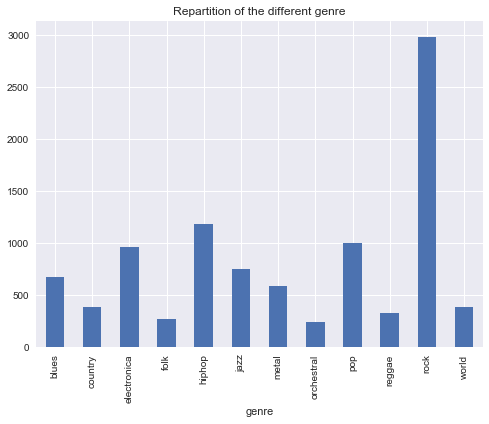

In [24]:
fig = plt.figure(figsize=(8,6))
df.groupby('genre')['genre'].count().plot('bar',title='Repartition of the different genre')

**Choose color(meaniful) for each genre: **
https://xkcd.com/color/rgb/

In [25]:
genre_color={'blues':'#75bbfd','country':'#653700','electronica':'#9a0eea','folk':'#f97306','jazz':'#fac205',
             'pop':'#ff81c0','metal':'#000000','rock':'#2242c7','orchestral':'#929591','hiphop':'#e50000',
             'reggae':'#06470c','world':'#a0bf16'}

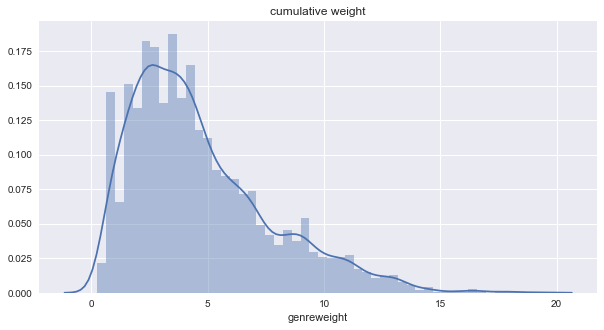

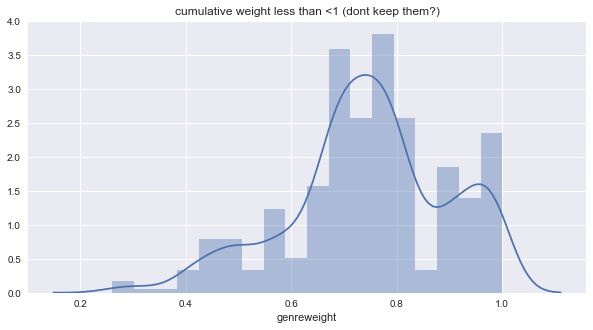

In [26]:
fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(111)
plt.title('cumulative weight')
sns.distplot(df['genreweight'],ax=ax)

fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(111)
plt.title('cumulative weight less than <1 (dont keep them?)')
sns.distplot(df['genreweight'][df['genreweight']<1],ax=ax)

**first look at the year distribution**

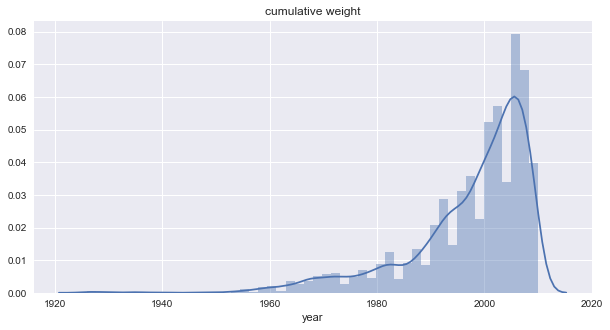

In [27]:
fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(111)
plt.title('cumulative weight')
df['year'] = df['year'].astype(int)
sns.distplot(df.loc[df['year']!=0,'year'],ax=ax)

**first look at the length distribution**

#duration=0 :  0


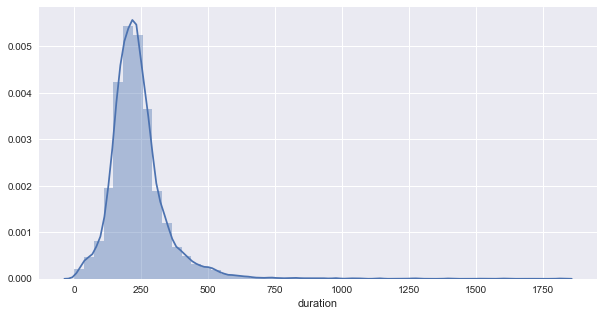

In [28]:
print('#duration=0 : ',len(df[df['duration']==0]))
fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(111)
sns.distplot(df['duration'][df['duration']!=0],ax=ax)

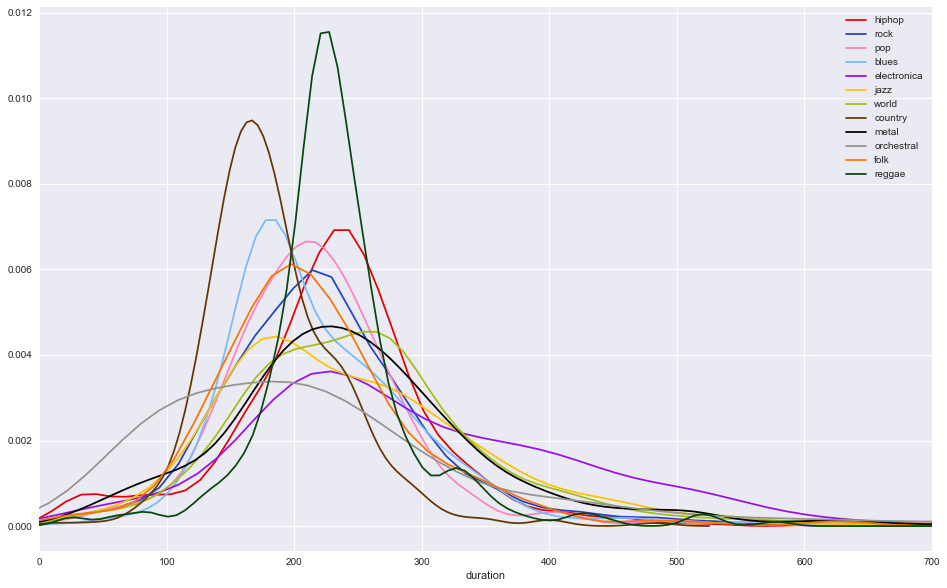

In [29]:
fig = plt.figure(figsize=(16,10))
ax = fig.add_subplot(111)
for genre in df['genre'].unique():
    dt=df[df['genre']==genre]
    g =sns.distplot(dt['duration'][dt['duration']!=0],hist=False,label=genre,color=genre_color[genre],ax=ax)
    g.set(xlim=(0, 700))

## Understand artist tags
TODO: What's the difference between weights and frequency should we take that into account ?

frequencey is it like frequency on the all database?  rock -> 1

In [30]:
def understand_artist_tags():
    for root, dirs, files in os.walk(msd_subset_data_path):
        files = glob.glob(os.path.join(root,'*'+'.h5'))
        for f in files:
            h5 = GETTERS.open_h5_file_read(f)

            print(GETTERS.get_artist_terms(h5))
            print(GETTERS.get_artist_terms_freq(h5))
            print(GETTERS.get_artist_terms_weight(h5))
            print('')

            h5.close()
  

### Map visualization
Let's display the rock music evolution over time

In [31]:
import folium
from folium import plugins

map_hooray = folium.Map([48., 5.], tiles='stamentoner', zoom_start=2) 

data = df.loc[df.genre == "rock"]

# Ensure you're handing it floats
#data['latitude'] = data['latitude'].astype(float)
#data['longitude'] = data['longitude'].astype(float)

# Filter the DF for rows, then columns, then remove NaNs
heat_df = data.dropna()
heat_df = data.loc[data.year != 0]
heat_df = heat_df[['latitude', 'longitude']]

# Create weight column, using date
heat_df['Weight'] = data['year']
heat_df['Weight'] = heat_df['Weight'].astype(float)
heat_df = heat_df.dropna(axis=0, subset=['latitude','longitude', 'Weight'])

# List comprehension to make out list of lists
heat_data = [[[row['latitude'],row['longitude']] for index, row in heat_df[heat_df['Weight'] == i].iterrows()] for i in range(1955,2000)]

# Plot it on the map
hm = plugins.HeatMapWithTime(heat_data,auto_play=True,max_opacity=0.8)
hm.add_to(map_hooray)
# Display the map
map_hooray